# Investigate effects of CPU binding of component on Aurora

In [1]:
# Set up notebook
import os
import pathlib
import glob
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

from datetime import datetime

font = {
        'family' : 'serif',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

import matplotlib.font_manager
# matplotlib.font_manager.fontManager.ttflist

In [68]:
class Performance:
    def __init__(self,path):
        self.base_path = path

    def get_sim_runtime(self,string):
        return string.split(":")[1].strip()
    
    def get_sim_sr_time(self,string,keyword):
        tmp = string.strip(keyword).lstrip()
        return list(map(float,tmp.split()))[2]
    
    def get_ml_time(self,string):
        tmp = string.split(":")[1].strip()
        tmp = tmp.split(",")[1]
        return float(tmp.split("=")[1].strip())

    def parse_files(self):
        path = self.base_path+'/cfdml/'
        run_dirs = glob.glob(path+'/*/')
        num_dirs = len(run_dirs)
        
        # Initialize arrays
        self.sim_runtime = np.zeros((num_dirs,))
        self.sim_steps = np.zeros((num_dirs,))
        self.sim_sr_init = np.zeros((num_dirs,))
        self.sim_sr_meta = np.zeros((num_dirs,))
        self.sim_sr_train = np.zeros((num_dirs,))
        self.sim_sr_sum = np.zeros((num_dirs,))
        self.sim_sr_oh = np.zeros((num_dirs,))
        self.ml_runtime = np.zeros((num_dirs,))
        self.ml_sr_init = np.zeros((num_dirs,))
        self.ml_sr_meta = np.zeros((num_dirs,))
        self.ml_sr_train = np.zeros((num_dirs,))
        self.ml_sr_sum = np.zeros((num_dirs,))
        self.ml_sr_oh = np.zeros((num_dirs,))
        
        # Loop over runs found
        i = 0
        for run_dir in run_dirs:
            print('Reading case directory: ', run_dir)
            
            # Simulation file
            with open(run_dir+'sim/sim.out','r') as fh:
                for l in fh:
                    if "Time taken for solution (sec):" in l:
                        self.sim_runtime[i] = self.get_sim_runtime(l)
                    if "SmartRedis_Init" in l:
                        self.sim_sr_init[i] = self.get_sim_sr_time(l,"SmartRedis_Init")
                    if "SmartRedis_Meta" in l:
                        self.sim_sr_meta[i] += self.get_sim_sr_time(l,"SmartRedis_Meta")
                    if "SmartRedis_Train" in l:
                        self.sim_sr_train[i] = self.get_sim_sr_time(l,"SmartRedis_Train")
                self.sim_sr_sum[i] = self.sim_sr_init[i]+self.sim_sr_meta[i]+self.sim_sr_train[i]
                self.sim_sr_oh[i] = self.sim_sr_sum[i]/self.sim_runtime[i]
    
            # Training file
            with open(run_dir+'/train/train.out','r') as fh:
                for l in fh:
                    if "Total training time" in l:
                        self.ml_runtime[i] = self.get_ml_time(l)
                    if "SmartRedis client initialization" in l:
                        self.ml_sr_init[i] = self.get_ml_time(l)
                    if "SmartRedis metadata transfer" in l:
                        self.ml_sr_meta[i] = self.get_ml_time(l)
                    if "SmartRedis training batch data transfer" in l:
                        self.ml_sr_train[i] = self.get_ml_time(l)
                self.ml_sr_sum[i] = self.ml_sr_init[i]+self.ml_sr_meta[i]+self.ml_sr_train[i]
                self.ml_sr_oh[i] = self.ml_sr_sum[i]/self.ml_runtime[i]
            
            i+=1

In [69]:
top_dir = "/Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/cpu_bindind/workflow_ml_on_gpu"

In [70]:
## DB on last 4 cores, both hyperthreads, socket 1 only
# sim_cpu_bind: "list:1:8:16:24:32:40:53:60:68:76"
# ml_cpu_bind: "list:84:92"
# db_cpu_bind: [100,204,101,205,102,206,103,207]
path = top_dir+"/config_1"
cfg1 = Performance(path)
cfg1.parse_files()

Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/cpu_bindind/workflow_ml_on_gpu/config_1/cfdml/21-08-2024_17-23-48/


In [71]:
## DB on last 8 cores, both hyperthreads, socket 1 only
# sim_cpu_bind: "list:1:8:16:24:32:40:53:60:68:76"
# ml_cpu_bind: "list:84:92"
# db_cpu_bind: [96,200,97,201,98,202,99,203,100,204,101,205,102,206,103,207]
path = top_dir+"/config_2"
cfg2 = Performance(path)
cfg2.parse_files()

Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/cpu_bindind/workflow_ml_on_gpu/config_2/cfdml/21-08-2024_17-30-48/


In [72]:
## DB on last 4 cores, 1 hyperthread only, socket 1 only
# sim_cpu_bind: "list:1:8:16:24:32:40:53:60:68:76"
# ml_cpu_bind: "list:84:92"
# db_cpu_bind: [100,101,102,103]
path = top_dir+"/config_3"
cfg3 = Performance(path)
cfg3.parse_files()

Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/cpu_bindind/workflow_ml_on_gpu/config_3/cfdml/21-08-2024_17-35-20/


In [73]:
## DB on last 4 cores of both sockets, 1 hyperthread only
# sim_cpu_bind: "list:1:8:16:24:32:40:53:60:68:76"
# ml_cpu_bind: "list:84:92"
# db_cpu_bind: [48,49,50,51,100,101,102,103]
path = top_dir+"/config_4"
cfg4 = Performance(path)
cfg4.parse_files()

Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/cpu_bindind/workflow_ml_on_gpu/config_4/cfdml/21-08-2024_17-35-48/


In [74]:
## DB on last 2 cores, 1 hyperthread only, socket 1 only
# sim_cpu_bind: "list:1:8:16:24:32:40:53:60:68:76"
# ml_cpu_bind: "list:84:92"
# db_cpu_bind: [102,103]
path = top_dir+"/config_5"
cfg5 = Performance(path)
cfg5.parse_files()

Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/cpu_bindind/workflow_ml_on_gpu/config_5/cfdml/21-08-2024_17-52-07/


In [75]:
## DB on last 2 cores of both sockets, 1 hyperthread only
# sim_cpu_bind: "list:1:8:16:24:32:40:53:60:68:76"
# ml_cpu_bind: "list:84:92"
# db_cpu_bind: [50,51,102,103]
path = top_dir+"/config_6"
cfg6 = Performance(path)
cfg6.parse_files()

Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/cpu_bindind/workflow_ml_on_gpu/config_6/cfdml/21-08-2024_17-54-30/


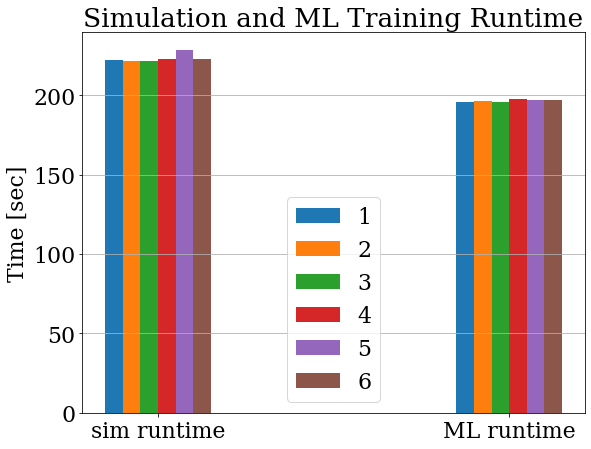

In [76]:
# Plot results
labels = ['sim runtime', 'ML runtime']
x = np.arange(len(labels))  # the label locations
width = 0.05  # the width of the bars
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 7))

axs.bar(x-2.5*width, [np.mean(cfg1.sim_runtime), np.mean(cfg1.ml_runtime)], width, 
                  yerr=[np.std(cfg1.sim_runtime), np.std(cfg1.ml_runtime)],label='1')
axs.bar(x-1.5*width, [np.mean(cfg2.sim_runtime), np.mean(cfg2.ml_runtime)], width, 
                  yerr=[np.std(cfg2.sim_runtime), np.std(cfg2.ml_runtime)],label='2')
axs.bar(x-0.5*width, [np.mean(cfg3.sim_runtime), np.mean(cfg3.ml_runtime)], width, 
                  yerr=[np.std(cfg3.sim_runtime), np.std(cfg3.ml_runtime)],label='3')
axs.bar(x+0.5*width, [np.mean(cfg4.sim_runtime), np.mean(cfg4.ml_runtime)], width, 
                  yerr=[np.std(cfg4.sim_runtime), np.std(cfg4.ml_runtime)],label='4')
axs.bar(x+1.5*width, [np.mean(cfg5.sim_runtime), np.mean(cfg5.ml_runtime)], width, 
                  yerr=[np.std(cfg5.sim_runtime), np.std(cfg5.ml_runtime)],label='5')
axs.bar(x+2.5*width, [np.mean(cfg6.sim_runtime), np.mean(cfg6.ml_runtime)], width, 
                  yerr=[np.std(cfg6.sim_runtime), np.std(cfg6.ml_runtime)],label='6')
axs.set_ylabel('Time [sec]')
axs.set_title('Simulation and ML Training Runtime')
axs.set_xticks(x);axs.set_xticklabels(labels)
#axs.set_xticks(x, labels)
axs.legend()
axs.grid(axis='y')

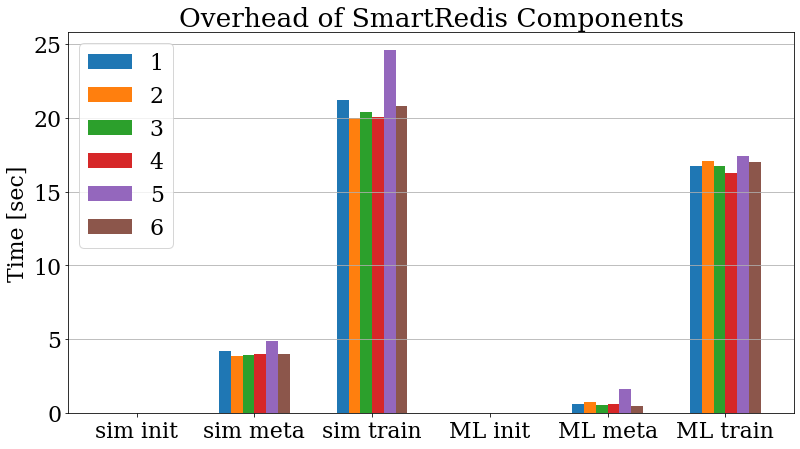

In [77]:
# Plot results
labels = ['sim init', 'sim meta', 'sim train', 'ML init', 'ML meta', 'ML train']
x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(13, 7))

cfg1_avg = [np.mean(cfg1.sim_sr_init), np.mean(cfg1.sim_sr_meta), np.mean(cfg1.sim_sr_train),
       np.mean(cfg1.ml_sr_init), np.mean(cfg1.ml_sr_meta), np.mean(cfg1.ml_sr_train)]
cfg1_std = [np.std(cfg1.sim_sr_init), np.std(cfg1.sim_sr_meta), np.std(cfg1.sim_sr_train),
       np.std(cfg1.ml_sr_init), np.std(cfg1.ml_sr_meta), np.std(cfg1.ml_sr_train)]
cfg2_avg = [np.mean(cfg2.sim_sr_init), np.mean(cfg2.sim_sr_meta), np.mean(cfg2.sim_sr_train),
       np.mean(cfg2.ml_sr_init), np.mean(cfg2.ml_sr_meta), np.mean(cfg2.ml_sr_train)]
cfg2_std = [np.std(cfg2.sim_sr_init), np.std(cfg2.sim_sr_meta), np.std(cfg2.sim_sr_train),
       np.std(cfg2.ml_sr_init), np.std(cfg2.ml_sr_meta), np.std(cfg2.ml_sr_train)]
cfg3_avg = [np.mean(cfg3.sim_sr_init), np.mean(cfg3.sim_sr_meta), np.mean(cfg3.sim_sr_train),
       np.mean(cfg3.ml_sr_init), np.mean(cfg3.ml_sr_meta), np.mean(cfg3.ml_sr_train)]
cfg3_std = [np.std(cfg3.sim_sr_init), np.std(cfg3.sim_sr_meta), np.std(cfg3.sim_sr_train),
       np.std(cfg3.ml_sr_init), np.std(cfg3.ml_sr_meta), np.std(cfg3.ml_sr_train)]
cfg4_avg = [np.mean(cfg4.sim_sr_init), np.mean(cfg4.sim_sr_meta), np.mean(cfg4.sim_sr_train),
       np.mean(cfg4.ml_sr_init), np.mean(cfg4.ml_sr_meta), np.mean(cfg4.ml_sr_train)]
cfg4_std = [np.std(cfg4.sim_sr_init), np.std(cfg4.sim_sr_meta), np.std(cfg4.sim_sr_train),
       np.std(cfg4.ml_sr_init), np.std(cfg4.ml_sr_meta), np.std(cfg4.ml_sr_train)]
cfg5_avg = [np.mean(cfg5.sim_sr_init), np.mean(cfg5.sim_sr_meta), np.mean(cfg5.sim_sr_train),
       np.mean(cfg5.ml_sr_init), np.mean(cfg5.ml_sr_meta), np.mean(cfg5.ml_sr_train)]
cfg5_std = [np.std(cfg5.sim_sr_init), np.std(cfg5.sim_sr_meta), np.std(cfg5.sim_sr_train),
       np.std(cfg5.ml_sr_init), np.std(cfg5.ml_sr_meta), np.std(cfg5.ml_sr_train)]
cfg6_avg = [np.mean(cfg6.sim_sr_init), np.mean(cfg6.sim_sr_meta), np.mean(cfg6.sim_sr_train),
       np.mean(cfg6.ml_sr_init), np.mean(cfg6.ml_sr_meta), np.mean(cfg6.ml_sr_train)]
cfg6_std = [np.std(cfg6.sim_sr_init), np.std(cfg6.sim_sr_meta), np.std(cfg6.sim_sr_train),
       np.std(cfg6.ml_sr_init), np.std(cfg6.ml_sr_meta), np.std(cfg6.ml_sr_train)]

axs.bar(x-2.5*width, cfg1_avg, width, yerr=cfg1_std,label='1')
axs.bar(x-1.5*width, cfg2_avg, width, yerr=cfg2_std,label='2')
axs.bar(x-0.5*width, cfg3_avg, width, yerr=cfg3_std,label='3')
axs.bar(x+0.5*width, cfg4_avg, width, yerr=cfg4_std,label='4')
axs.bar(x+1.5*width, cfg5_avg, width, yerr=cfg5_std,label='5')
axs.bar(x+2.5*width, cfg6_avg, width, yerr=cfg6_std,label='6')
axs.set_ylabel('Time [sec]')
axs.set_title('Overhead of SmartRedis Components')
axs.set_xticks(x);axs.set_xticklabels(labels)
#axs.set_xticks(x, labels)
axs.legend()
axs.grid(axis='y')

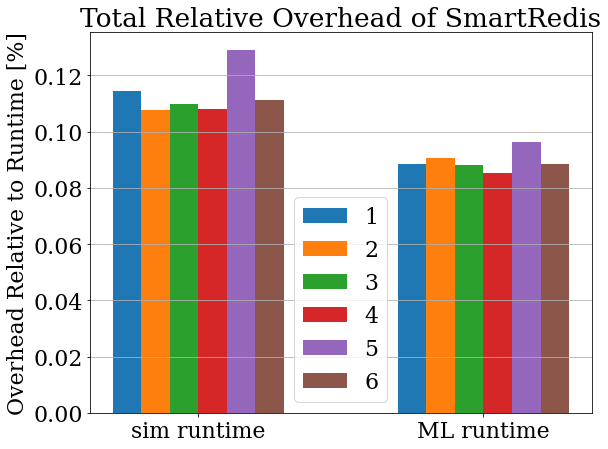

In [80]:
# Plot results
labels = ['sim runtime', 'ML runtime']
x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 7))
axs.bar(x-2.5*width, [np.mean(cfg1.sim_sr_oh), np.mean(cfg1.ml_sr_oh)], width, 
                  yerr=[np.std(cfg1.sim_sr_oh), np.std(cfg1.sim_sr_oh)],label='1')
axs.bar(x-1.5*width, [np.mean(cfg2.sim_sr_oh), np.mean(cfg2.ml_sr_oh)], width, 
                  yerr=[np.std(cfg2.sim_sr_oh), np.std(cfg2.sim_sr_oh)],label='2')
axs.bar(x-0.5*width, [np.mean(cfg3.sim_sr_oh), np.mean(cfg3.ml_sr_oh)], width, 
                  yerr=[np.std(cfg3.sim_sr_oh), np.std(cfg3.sim_sr_oh)],label='3')
axs.bar(x+0.5*width, [np.mean(cfg4.sim_sr_oh), np.mean(cfg4.ml_sr_oh)], width, 
                  yerr=[np.std(cfg4.sim_sr_oh), np.std(cfg4.sim_sr_oh)],label='4')
axs.bar(x+1.5*width, [np.mean(cfg5.sim_sr_oh), np.mean(cfg5.ml_sr_oh)], width, 
                  yerr=[np.std(cfg5.sim_sr_oh), np.std(cfg5.sim_sr_oh)],label='5')
axs.bar(x+2.5*width, [np.mean(cfg6.sim_sr_oh), np.mean(cfg6.ml_sr_oh)], width, 
                  yerr=[np.std(cfg6.sim_sr_oh), np.std(cfg6.sim_sr_oh)],label='6')
axs.set_ylabel('Overhead Relative to Runtime [%]')
axs.set_title('Total Relative Overhead of SmartRedis')
axs.set_xticks(x);axs.set_xticklabels(labels)
#axs.set_xticks(x, labels)
axs.legend()
axs.grid(axis='y')